In [59]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["HUGGINGFACE_API_KEY"] = os.getenv("HUGGINGFACE_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")


In [60]:
from typing import Literal
from langchain_core.messages import AIMessage
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_core.output_parsers import PydanticOutputParser, StrOutputParser
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph, START, END
from langchain_tavily import TavilySearch

In [61]:
loader = DirectoryLoader("../data", glob="**/*.txt", loader_cls=TextLoader)
doc =  loader.load()

In [62]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [63]:
chunk = text_splitter.split_documents(doc)

In [64]:
chunk

[Document(metadata={'source': '..\\data\\usa.txt'}, page_content='ðŸ‡ºðŸ‡¸ Overview of the U.S. Economy'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services.'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='innovation, global trade

In [65]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [66]:
llm = ChatGroq(model_name="llama-3.3-70b-versatile")

In [67]:
len(embeddings.embed_query("Hello World"))

384

In [68]:
#sotre in chromadb
db = Chroma.from_documents(chunk, embeddings)

In [69]:
retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 2})

In [70]:
retriever.invoke("GDP of USA?")

[Document(metadata={'source': '..\\data\\usa.txt'}, page_content='As of 2024, the United Statesâ€™ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='As of 2024, the United Statesâ€™ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of')]

In [89]:
class TopicSelection(BaseModel):
    topic: str = Field(description="The topic of the conversation")
    reasoning: str = Field(description="The reasoning behind the topic selection")

In [90]:
class RouteQuery(BaseModel):
    step: Literal['llm', 'rag', 'web_scraper'] = Field(description="The next step in the workflow")
    reasoning: str = Field(description="Reasoning for the selection")


In [91]:
parser = PydanticOutputParser(pydantic_object=RouteQuery)

In [92]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [93]:
# supervisor node
def supervisor_node(state: AgentState):
    # Robustly handle input (could be string or Message object)
    last_message = state['messages'][-1]
    question = last_message.content if hasattr(last_message, 'content') else str(last_message)
    
    template = """
    You are a supervisor tasked with managing a conversation flow.
    Your task is to decide the next step based on the user query.
    
    Options:
    - llm: General queries, chit-chat, or questions not requiring external data.
    - rag: Questions about specific documents or knowledge base (e.g., USA economy).
    - web_scraper: Questions requiring real-time internet search or current events.
    
    User Query: {question}
    
    {format_instructions}
    """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    chain = prompt | llm | parser
    
    try:
        decision_obj = chain.invoke({"question": question})
        decision = decision_obj.step
    except Exception as e:
        # Fallback to llm if parsing fails
        print(f"Supervisor error: {e}")
        decision = "llm"
        
    print(f"Supervisor decision: {decision}")
    return {"messages": [AIMessage(content=decision)]}


In [94]:
# router function
def router(state: AgentState):
    # Retrieve the decision from the last message added by supervisor
    last_message = state['messages'][-1]
    # The supervisor returns an AIMessage with the step name as content
    decision = last_message.content
    print(f"Routing to: {decision}")
    return decision


In [95]:
# llm node
def llm_node(state: AgentState):
    question = state['messages'][0]
    question_content = question.content if hasattr(question, 'content') else str(question)
    
    complete_query = "Answer the follow question wiht your knowledge: " + question_content
    response = llm.invoke(complete_query)
    # response is an AIMessage
    return {"messages": [response]}


In [119]:
# rag node
def rag_node(state: AgentState):
    question = state["messages"][0]
    question_content = question.content if hasattr(question, 'content') else str(question)

    prompt = PromptTemplate(
        template="""
        You are an assistant for question-answering tasks.
        Use the following pieces of retrieved context to answer the question.
        If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
        Context: {context}
        Question: {question}
        """,
        input_variables=["context", "question"],
    )
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
    )

    result = rag_chain.invoke(question_content)
    return {"messages": [AIMessage(content=result)]}


In [120]:
# web scraper node
def web_scraper_node(state: AgentState):
    question = state["messages"][0]
    question_content = question.content if hasattr(question, 'content') else str(question)
    
    tool = TavilySearch()
    try:
        response = tool.invoke(question_content)
        content = str(response)
    except Exception as e:
        content = f"Error searching web: {e}"
        
    return {"messages": [AIMessage(content=content)]}


In [121]:
# validation node
class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Whether the answer is valid and addresses the user query")
    reason: str = Field(description="Reason for the validation decision")

def validation_node(state: AgentState):
    user_query = state["messages"][0]
    generated_message = state["messages"][-1]
    
    user_query_content = user_query.content if hasattr(user_query, 'content') else str(user_query)
    generated_content = generated_message.content if hasattr(generated_message, 'content') else str(generated_message)
    
    validation_parser = PydanticOutputParser(pydantic_object=ValidationResult)
    
    template = """
    You are a quality assurance validator.
    
    User Query: {query}
    Generated Answer: {answer}
    
    Check if the Generated Answer validly and correctly answers the User Query.
    If the answer is "I don't know" or irrelevant, mark it as invalid.
    
    {format_instructions}
    """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=["query", "answer"],
        partial_variables={"format_instructions": validation_parser.get_format_instructions()}
    )
    
    chain = prompt | llm | validation_parser
    
    try:
        validation_result = chain.invoke({"query": user_query_content, "answer": generated_content})
        decision = "valid" if validation_result.is_valid else "invalid"
    except Exception as e:
        print(f"Validation error: {e}")
        decision = "valid" # Default to valid if validation fails
        
    return {"messages": [AIMessage(content=decision)]}


def validation_router(state: AgentState):
    # Retrieve the validation decision
    last_message = state['messages'][-1]
    decision = last_message.content if hasattr(last_message, 'content') else str(last_message)
    
    if decision == "valid":
        return "valid"
    else:
        return "invalid"


In [122]:
workflow = StateGraph(AgentState)

In [123]:
workflow.add_node("supervisor", supervisor_node)
workflow.add_node("llm", llm_node)
workflow.add_node("rag", rag_node)
workflow.add_node("web_scraper", web_scraper_node)
workflow.add_node("validator", validation_node)


In [124]:
workflow.set_entry_point("supervisor")

In [125]:
workflow.add_conditional_edges(
    "supervisor",
    router,
    {
        "llm": "llm",
        "rag": "rag",
        "web_scraper": "web_scraper",
    }
)


In [126]:
workflow.add_edge("rag", "validator")
workflow.add_edge("llm", "validator")
workflow.add_edge("web_scraper", "validator")

workflow.add_conditional_edges(
    "validator",
    validation_router,
    {
        "valid": END,
        "invalid": "supervisor"
    }
)


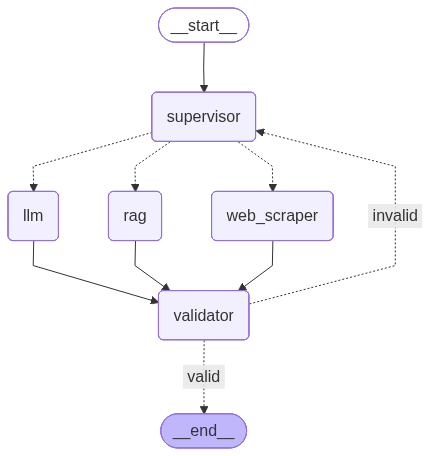

In [127]:
workflow.compile()

In [128]:
app = workflow.compile()

In [134]:
app.invoke({"messages": ["current wearther in bangalore?"]})

Supervisor decision: web_scraper
Routing to: web_scraper


{'messages': ['current wearther in bangalore?',
  AIMessage(content='web_scraper', additional_kwargs={}, response_metadata={}, tool_calls=[], invalid_tool_calls=[]),
  AIMessage(content='{\'query\': \'current wearther in bangalore?\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'url\': \'https://www.accuweather.com/en/in/bengaluru/204108/current-weather/204108\', \'title\': \'Bengaluru, Karnataka, India Current Weather - AccuWeather\', \'content\': \'Current Weather. 11:04 PM. 67°F. Mostly clear. RealFeel® 63°. Pleasant. RealFeel Guide. Pleasant. 63° to 81°. Most consider this temperature range ideal. LEARN\', \'score\': 0.8455478, \'raw_content\': None}, {\'url\': \'https://www.aqi.in/weather/india/karnataka/bangalore\', \'title\': \'Bangalore Weather Conditions: Temperature | 30 Days Forecast\', \'content\': \'Current Bangalore weather condition is Sunny with real-time temperature (25°C), humidity 41%, wind 16.6km/h, pressure (1021mb), UV (11), vi

In [135]:
app.invoke({"messages": ["Industrial growth of USA?"]})

Supervisor decision: rag
Routing to: rag


{'messages': ['Industrial growth of USA?',
  AIMessage(content='rag', additional_kwargs={}, response_metadata={}, tool_calls=[], invalid_tool_calls=[]),
  AIMessage(content="The U.S. economy is considered the engine of global growth. It has a strong GDP of $28 trillion, driven by unmatched innovation and financial dominance. The country's industrial growth is thus significant, backed by its robust institutional framework.", additional_kwargs={}, response_metadata={}, tool_calls=[], invalid_tool_calls=[]),
  AIMessage(content='valid', additional_kwargs={}, response_metadata={}, tool_calls=[], invalid_tool_calls=[])]}

In [136]:
app.invoke({"messages": ["Hi"]})

Supervisor decision: llm
Routing to: llm


{'messages': ['Hi',
  AIMessage(content='llm', additional_kwargs={}, response_metadata={}, tool_calls=[], invalid_tool_calls=[]),
  AIMessage(content='It looks like you didn\'t ask a question. You just said "Hi". If you\'d like to ask a question or start a conversation, I\'m here to help. What\'s on your mind?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 45, 'total_tokens': 87, 'completion_time': 0.089049937, 'completion_tokens_details': None, 'prompt_time': 0.002183842, 'prompt_tokens_details': None, 'queue_time': 0.053608337, 'total_time': 0.091233779}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c1837-0b48-72e3-86ef-df8f1c67816d-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 45, 'output_tokens': 42, 'total_tokens': 87}),
  AIMessage(content='valid', addi